# Modelling Experiments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
cwd = os.getcwd()
print(cwd)

c:\Users\danie\Documents\GitHub\thesis\modelling


In [3]:
df = pd.read_csv('../Data/gold/covid_multivariate_w_2.csv')
df.head()

,date,country,new_cases,cases,co,no2,o3,pm10,pm25,so2,year,population,Mean_distance_avg_14day_movavg,StringencyIndex_Average
0,2020-03-23,Chile,1558,10261,5.828571,5.242857,10.619048,28.350649,37.952381,3.773810,2020,19331414,19.456667,69.844286
1,2020-03-30,Chile,2420,24909,5.978571,6.516667,13.771429,38.922078,50.726190,4.035714,2020,19331414,12.998571,75.930000
2,2020-04-06,Chile,2987,43938,6.235714,6.992857,12.733333,43.142857,66.071429,3.840476,2020,19331414,11.041429,75.930000
3,2020-04-13,Chile,3304,65523,7.383333,8.771429,11.707143,43.233766,69.059524,4.076190,2020,19331414,10.270000,75.930000
4,2020-04-20,Chile,4054,90640,6.742857,6.788095,11.769048,38.662338,63.321429,3.661905,2020,19331414,10.878571,75.930000


# Wrangle

In [4]:
df['cases_t_4'] = df.groupby('country')['new_cases'].shift(-4)
df['cases_t_1'] = df.groupby('country')['new_cases'].shift(-1)

In [5]:
df['cases_lag1'] = df.groupby('country')['cases'].shift(1)

In [6]:
print(df['cases_t_4'].isnull().sum(), 'Nans for cases_t_4')
print(df['cases_t_1'].isnull().sum(), 'Nans for cases_t_1')
print(df['cases_lag1'].isnull().sum(), 'Nans for cases_lag1')

20 Nans for cases_t_4
5 Nans for cases_t_1
5 Nans for cases_lag1


In [7]:
# drop if cases_t_4 is null
df = df.dropna(subset=['cases_t_4'])
df = df.dropna(subset=['cases_t_1'])
df = df.dropna(subset=['cases_lag1'])

In [8]:
# convert date to numeric
df['date'] = pd.to_datetime(df['date'])
df['date_numeric'] = df['date'].apply(lambda x: x.timestamp())

In [9]:
df_og = df.copy()

In [10]:
# dummies for countries
df = pd.get_dummies(df, columns=['country'], drop_first=True)

# Regression Framework

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


def plot_country_residuals_scaled(df, model):
    countries = df['country'].unique()
    n_countries = len(countries)

    fig, axes = plt.subplots(nrows=2, ncols=(n_countries + 1) // 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, country in enumerate(countries):
        # Filter data for the current country
        df_country = df[df['country'] == country]

        # Define explanatory and target variables
        y = df_country['new_cases']
        X = df_country.drop(columns=['cases','new_cases', 'cases_t_4','cases_t_1', 'date', 'country'])
        

        # Split data (80/20 split, time-series style)
        split_idx = int(len(df_country) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        dates_test = df_country['date'].iloc[split_idx:]

        # Scale data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit provided model on scaled data
        model.fit(X_train_scaled, y_train)

        # Predict and compute residuals
        y_pred = model.predict(X_test_scaled)
        residuals = y_test - y_pred

        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)

        # Plot residuals
        ax = axes[idx]
        ax.plot(dates_test, residuals, marker='o', linestyle='-', markersize=3)
        ax.axhline(y=0, color='red', linestyle='--')
        ax.set_title(f"{country} Residuals (MSE: {mse:.2f})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Residual")
        ax.tick_params(axis='x', rotation=45)

    # Remove any empty subplots
    for idx in range(n_countries, len(axes)):
        fig.delaxes(axes[idx])

    fig.tight_layout()
    plt.show()

# Example usage:
# from sklearn.linear_model import Lasso
# plot_country_residuals(df_og, Lasso(alpha=1.0))


# OLS

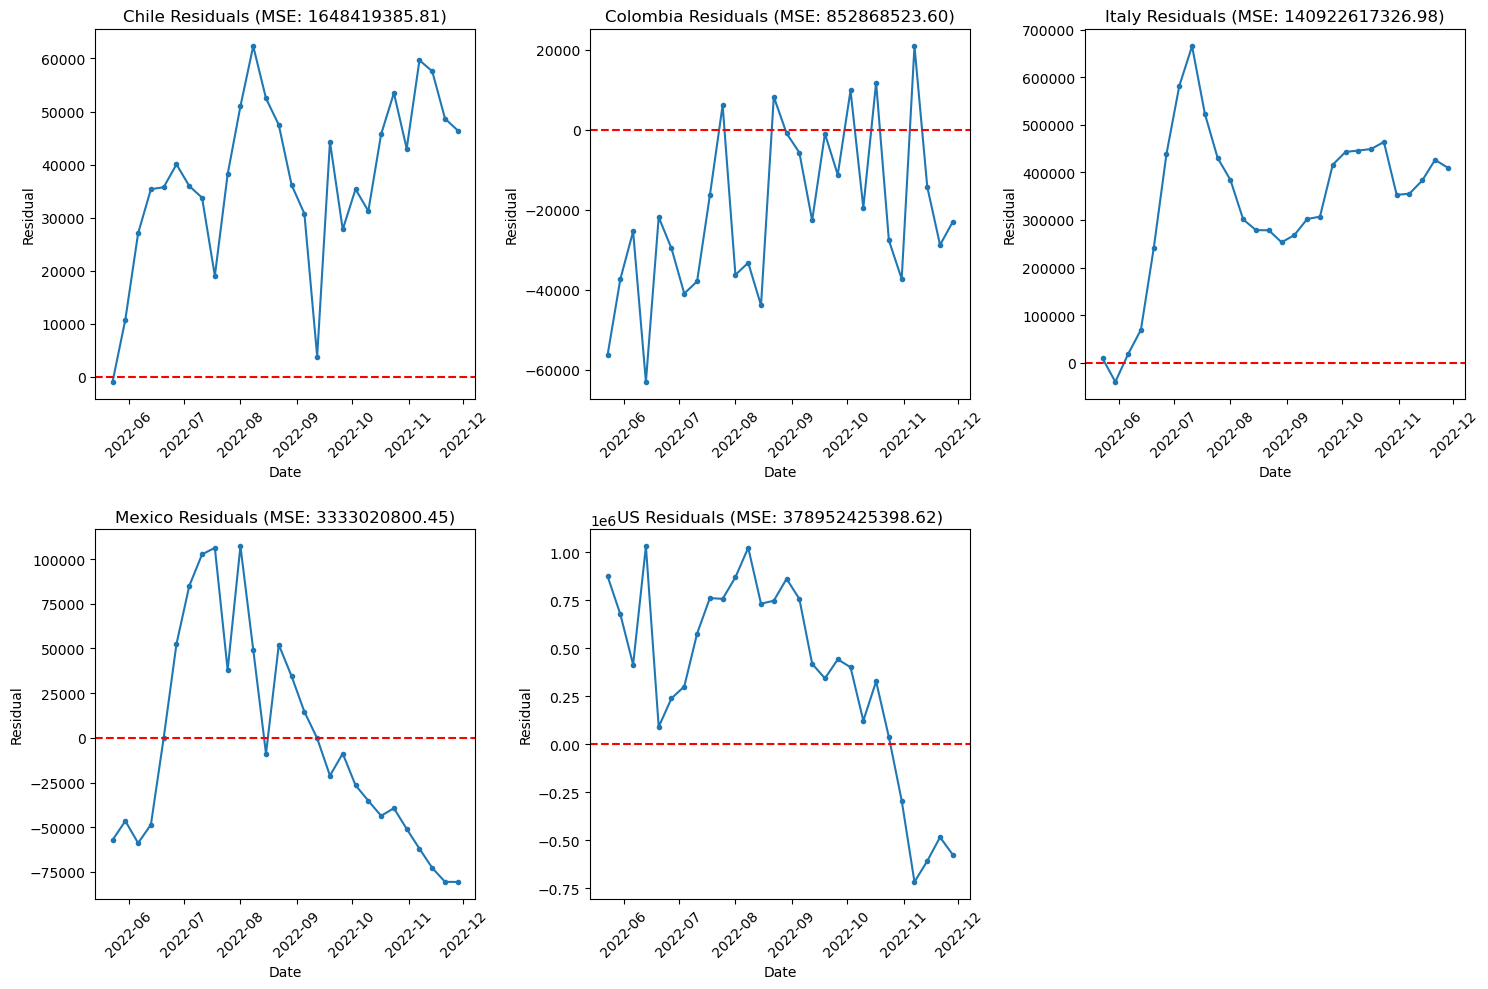

In [12]:
from sklearn.linear_model import LinearRegression
plot_country_residuals_scaled(df_og, LinearRegression())

## Lasso

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.985e+10, tolerance: 2.328e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.700e+10, tolerance: 3.285e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

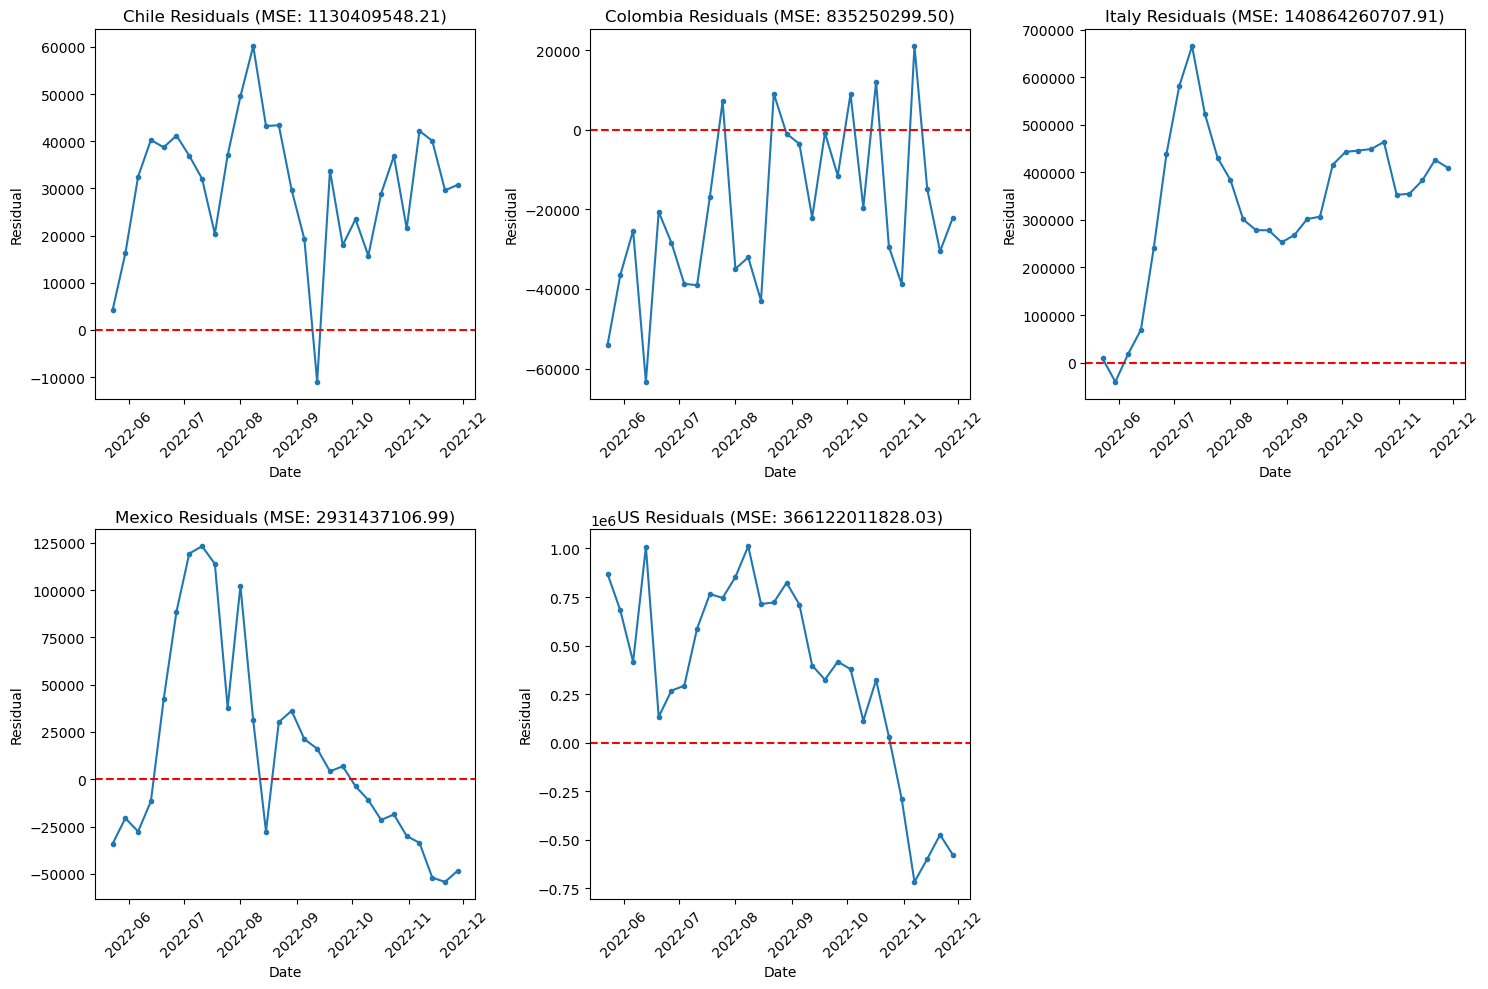

In [13]:
from sklearn.linear_model import Lasso
plot_country_residuals_scaled(df_og, Lasso(alpha=1.0))

## Ridge

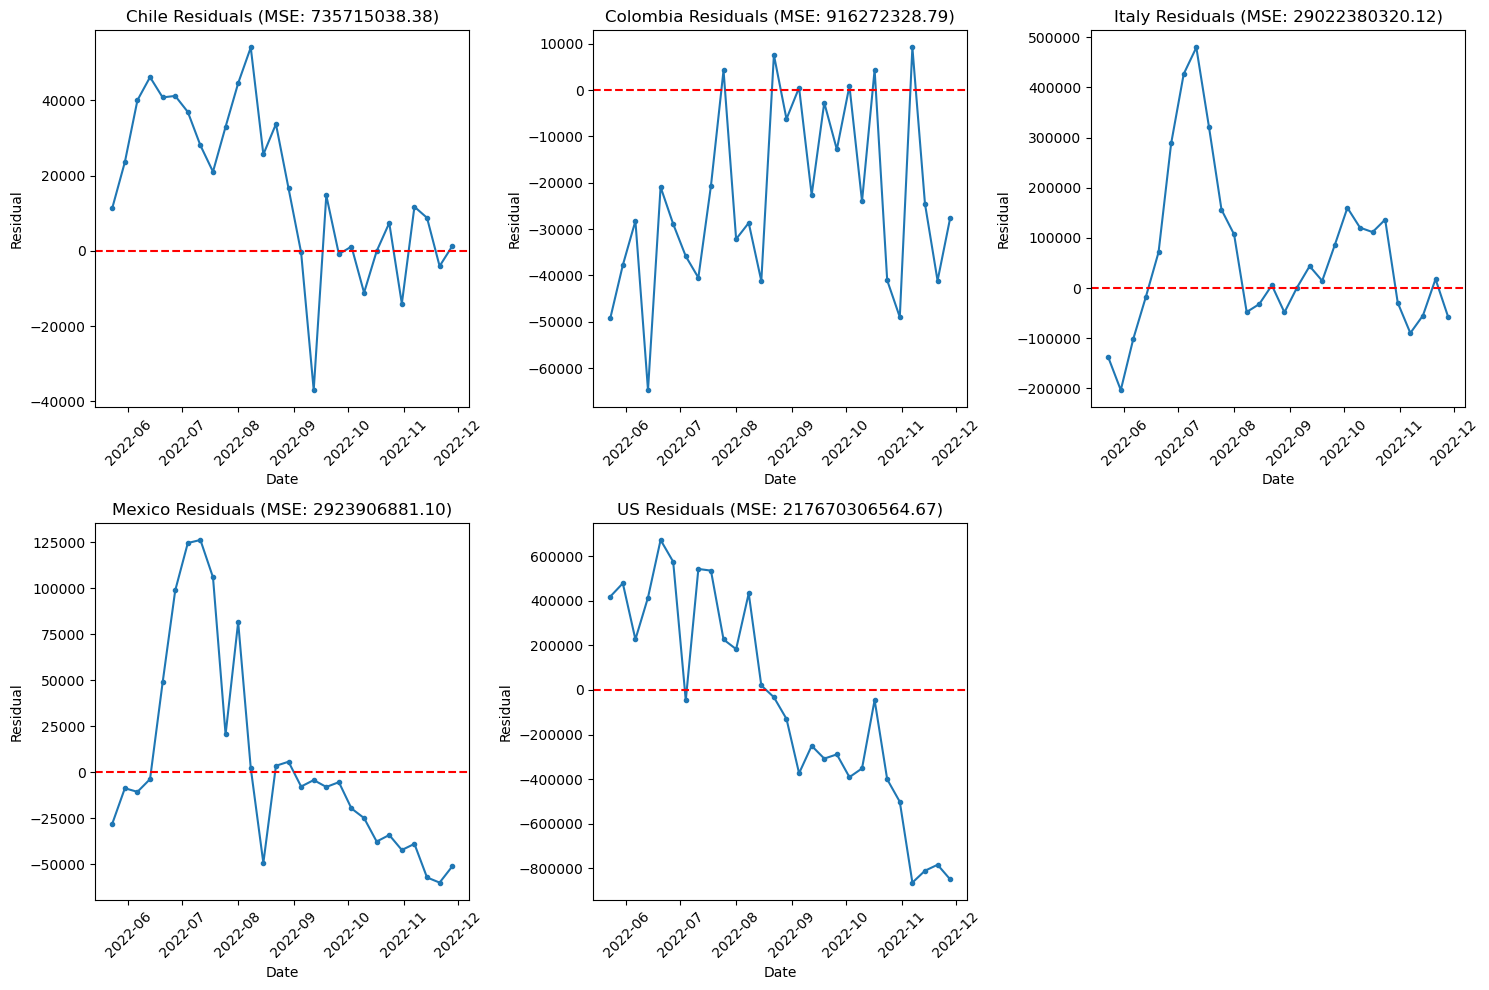

In [14]:
from sklearn.linear_model import Ridge
plot_country_residuals_scaled(df_og, Ridge(alpha=1.0))

## Elastic Net

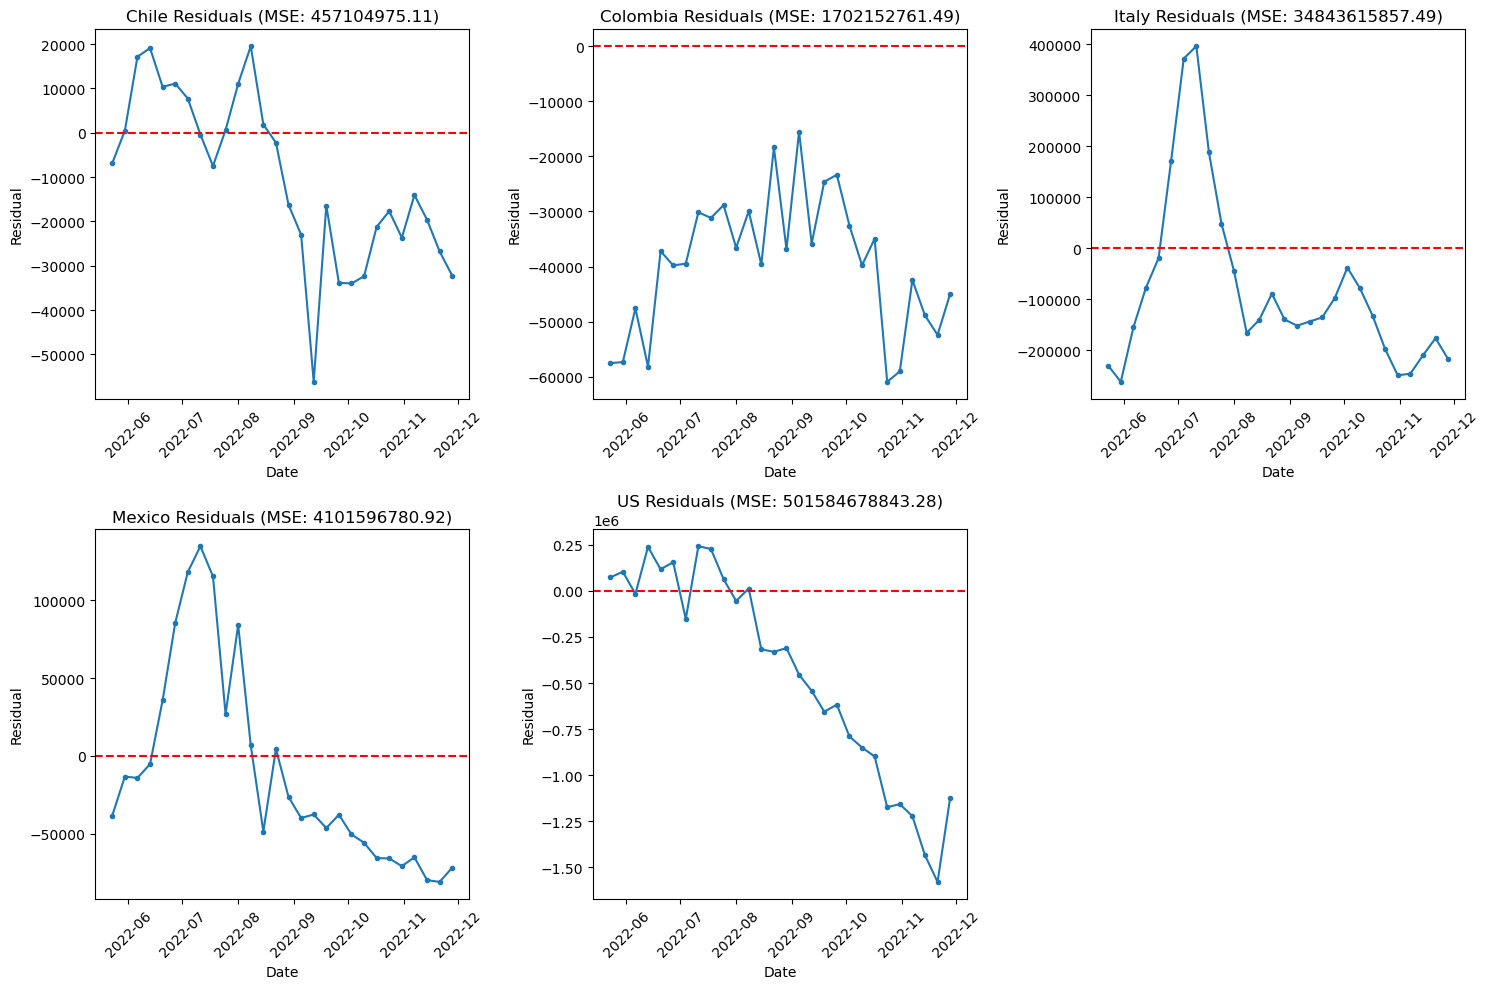

In [15]:
from sklearn.linear_model import ElasticNet
plot_country_residuals_scaled(df_og, ElasticNet(alpha=1.0, l1_ratio=0.5))

## Random Forest

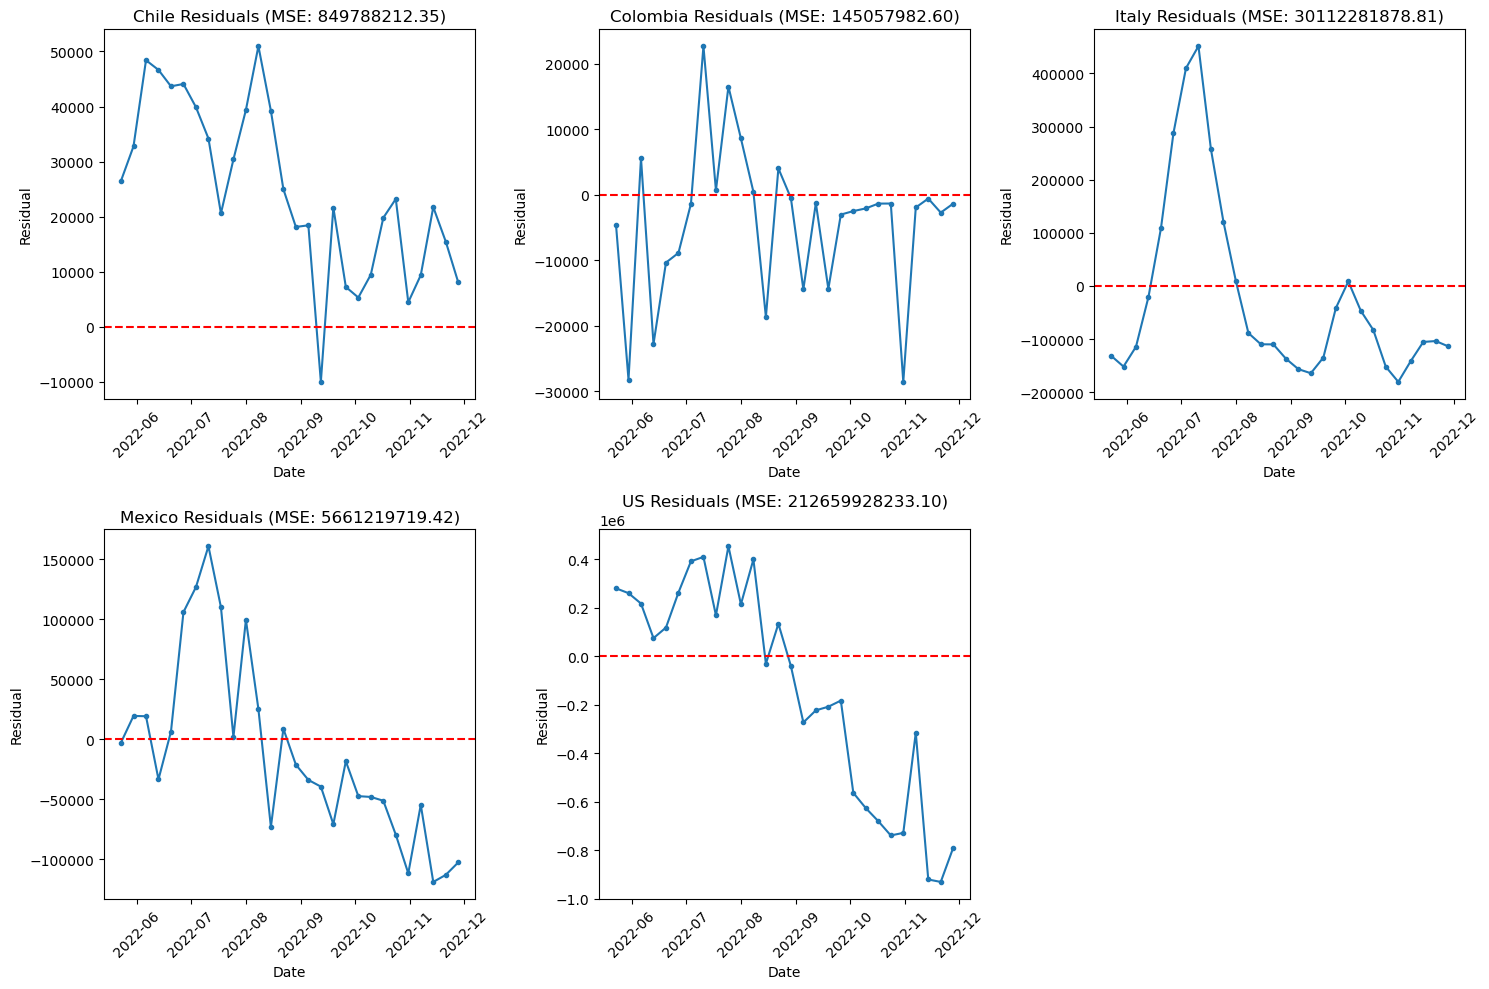

In [16]:
from sklearn.ensemble import RandomForestRegressor
plot_country_residuals_scaled(df_og, RandomForestRegressor())

## Gradient Boosting

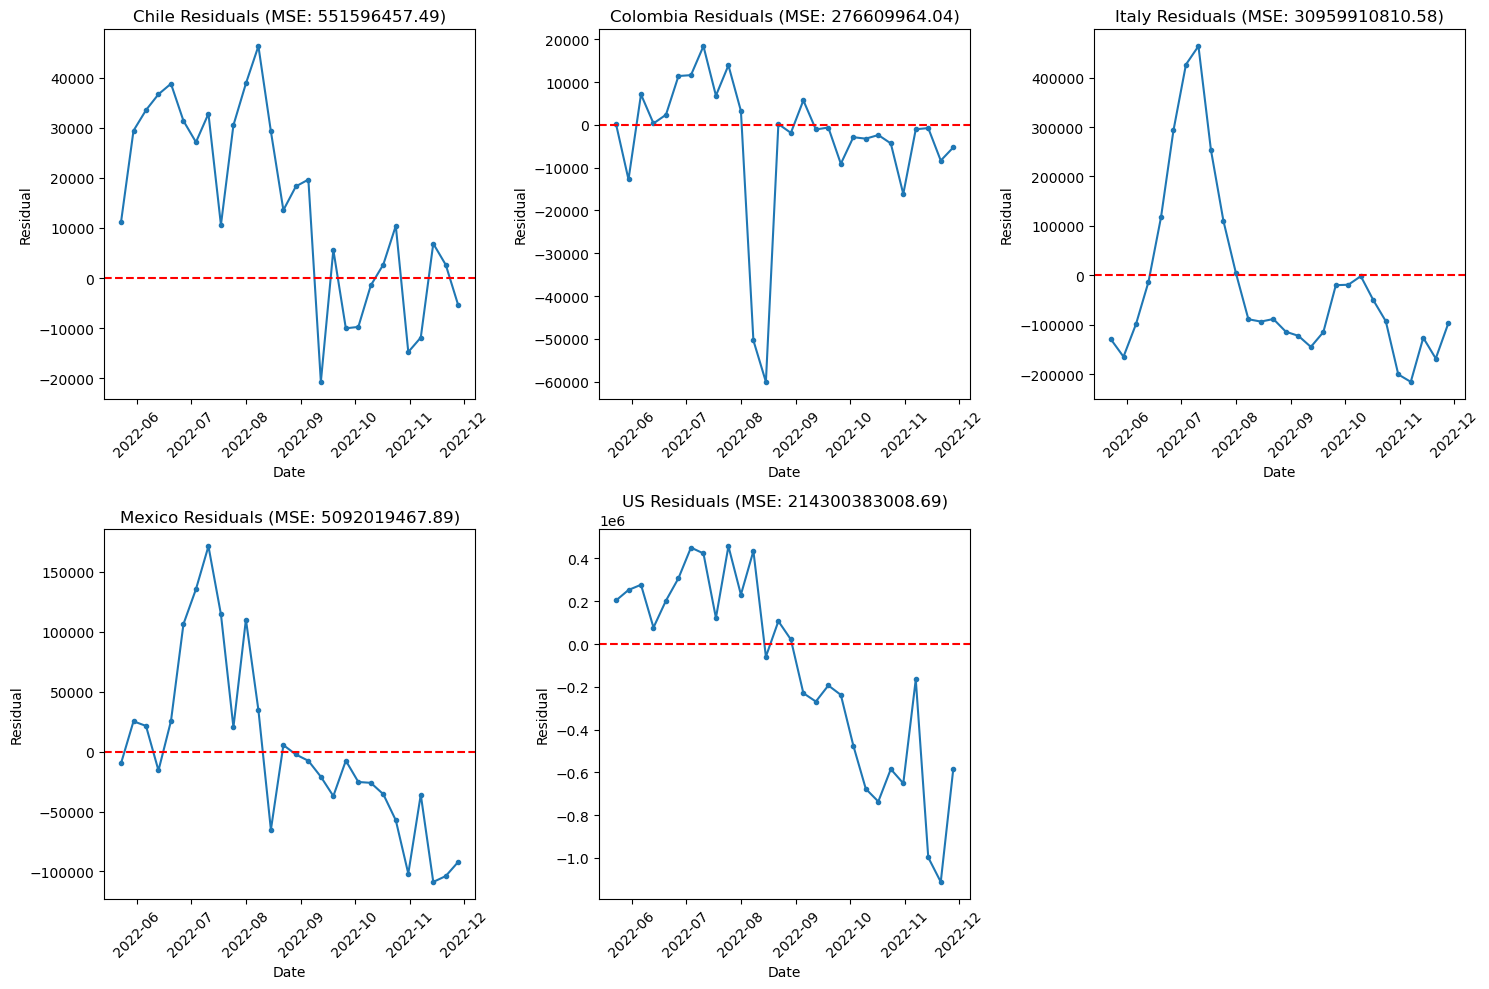

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
plot_country_residuals_scaled(df_og, GradientBoostingRegressor())

## SVM

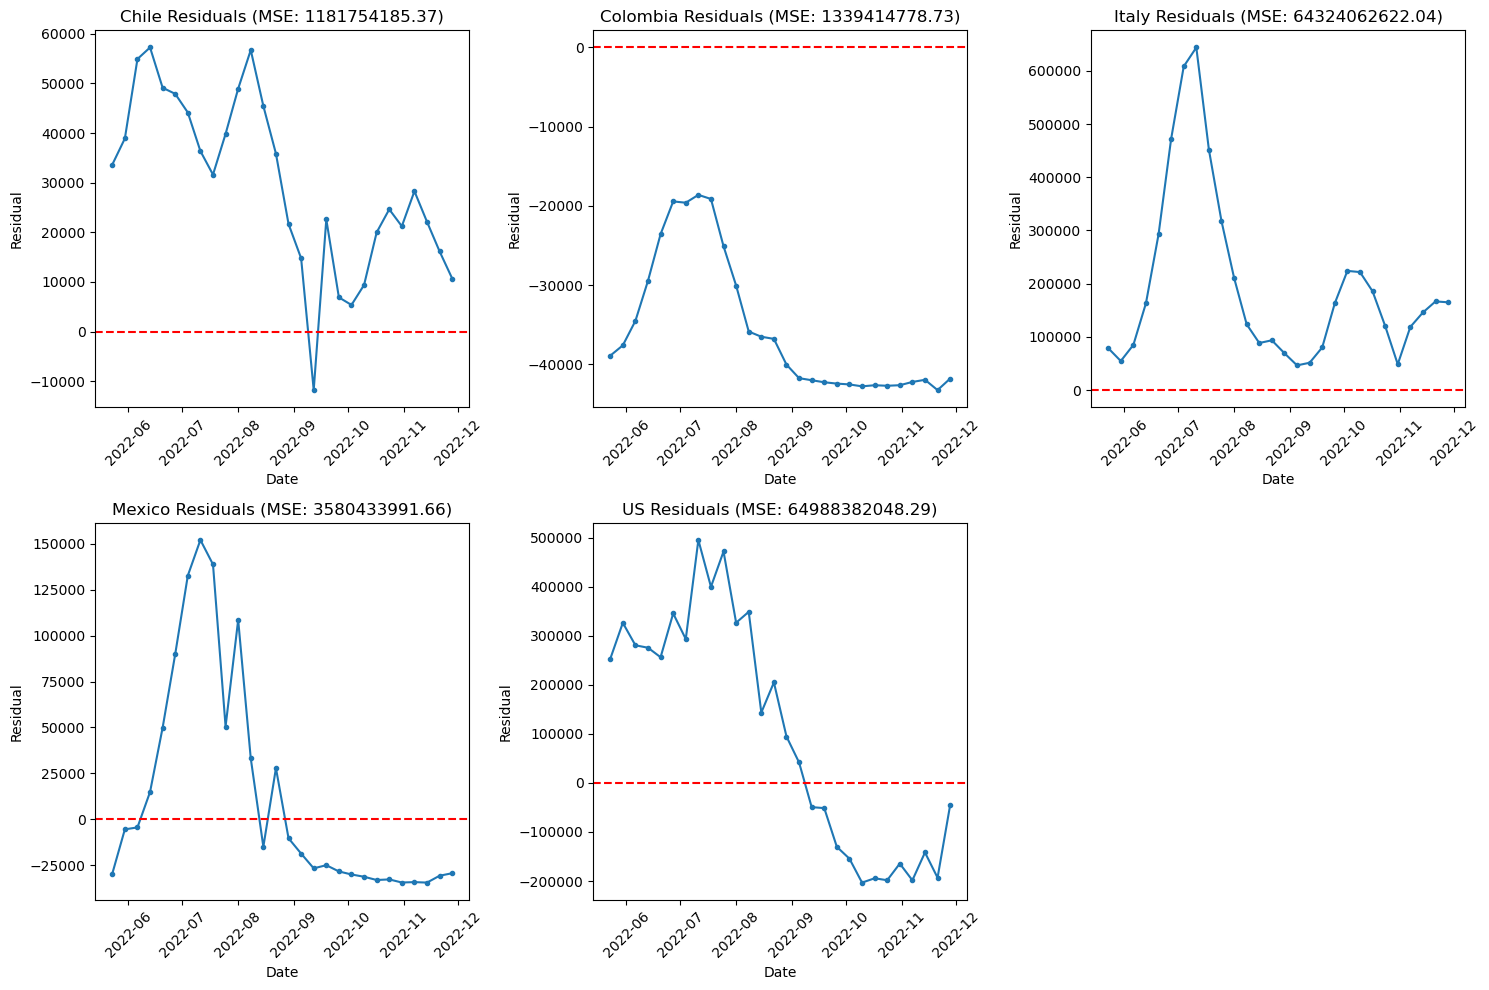

In [18]:
# do SVM regression
from sklearn.svm import SVR
plot_country_residuals_scaled(df_og, SVR(kernel='rbf'))

## Metrics

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import pandas as pd

def evaluate_models_per_country(df):
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0),
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='rbf')
    }

    countries = df['country'].unique()
    all_results = []

    for country in countries:
        df_country = df[df['country'] == country]

        y = df_country['new_cases']
        X = df_country.drop(columns=['cases','new_cases', 'cases_t_4','cases_t_1', 'date', 'country'])

        split_idx = int(len(df_country) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # Standard Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            all_results.append({
                'country': country,
                'model': model_name,
                'RMSE': rmse,
                'R2': r2
            })

    return pd.DataFrame(all_results)

In [20]:
# Example usage:
results_df = evaluate_models_per_country(df_og)
print(results_df)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.985e+10, tolerance: 2.328e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.700e+10, tolerance: 3.285e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

     country             model           RMSE         R2
0      Chile  LinearRegression   40600.731346  -4.542522
1      Chile             Lasso   33621.563738  -2.800804
2      Chile             Ridge   27124.067512  -1.473713
3      Chile        ElasticNet   21380.013450  -0.536936
4      Chile      RandomForest   28094.038656  -1.653799
5      Chile  GradientBoosting   23574.457998  -0.868629
6      Chile               SVR   34376.651748  -2.973442
7   Colombia  LinearRegression   29203.912813 -10.697065
8   Colombia             Lasso   28900.697215 -10.455432
9   Colombia             Ridge   30269.990565 -11.566646
10  Colombia        ElasticNet   41257.154064 -22.344972
11  Colombia      RandomForest   12633.549068  -1.188999
12  Colombia  GradientBoosting   16470.430730  -2.720529
13  Colombia               SVR   36598.016049 -17.370032
14     Italy  LinearRegression  375396.613366  -4.449768
15     Italy             Lasso  375318.878699  -4.447511
16     Italy             Ridge 

In [21]:
# Group by model and calculate the mean RMSE for each model
mean_rmse_per_model = results_df.groupby('model')['RMSE'].mean()

# Find the model with the lowest mean RMSE
best_model = mean_rmse_per_model.idxmin()
lowest_mean_rmse = mean_rmse_per_model.min()

print(f"The model with the lowest mean RMSE is {best_model} with a mean RMSE of {lowest_mean_rmse:.2f}")

The model with the lowest mean RMSE is SVR with a mean RMSE of 127872.29


In [22]:
mean_rmse_per_model

model
ElasticNet          204314.351313
GradientBoosting    148910.734134
Lasso               219412.811381
LinearRegression    223704.939290
RandomForest        155871.451729
Ridge               149675.657395
SVR                 127872.294929
Name: RMSE, dtype: float64

In [23]:
results_df[results_df['model'] == 'SVR']

,country,model,RMSE,R2
6,Chile,SVR,34376.651748,-2.973442
13,Colombia,SVR,36598.016049,-17.370032
20,Italy,SVR,253621.889083,-1.487544
27,Mexico,SVR,59836.727782,-0.044162
34,US,SVR,254928.189984,-0.187899


## Cases t+4
4 weeks later

In [24]:
def evaluate_models_per_country_4(df):
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0),
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='rbf')
    }

    countries = df['country'].unique()
    all_results = []

    for country in countries:
        df_country = df[df['country'] == country]

        y = df_country['cases_t_4']
        X = df_country.drop(columns=['cases_t_4', 'cases_t_1','date', 'country'])

        split_idx = int(len(df_country) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # Standard Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            all_results.append({
                'country': country,
                'model': model_name,
                'RMSE': rmse,
                'R2': r2
            })

    return pd.DataFrame(all_results)


In [25]:

results_df_4 = evaluate_models_per_country_4(df_og)
print(results_df_4)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e+10, tolerance: 2.329e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.553e+10, tolerance: 3.258e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

     country             model          RMSE          R2
0      Chile  LinearRegression  7.740616e+04  -20.689277
1      Chile             Lasso  6.280632e+04  -13.279098
2      Chile             Ridge  3.876612e+04   -4.439996
3      Chile        ElasticNet  1.880465e+04   -0.280043
4      Chile      RandomForest  3.012910e+04   -2.285992
5      Chile  GradientBoosting  4.178334e+04   -5.319756
6      Chile               SVR  2.824846e+04   -1.888574
7   Colombia  LinearRegression  1.160570e+05 -186.297456
8   Colombia             Lasso  1.256234e+05 -218.447117
9   Colombia             Ridge  4.674810e+04  -29.389036
10  Colombia        ElasticNet  1.061167e+04   -0.565874
11  Colombia      RandomForest  1.633254e+04   -2.709337
12  Colombia  GradientBoosting  2.648675e+04   -8.755432
13  Colombia               SVR  3.692765e+04  -17.962357
14     Italy  LinearRegression  1.997196e+05   -0.554395
15     Italy             Lasso  2.111964e+05   -0.738172
16     Italy             Ridge 

In [26]:
# Group by model and calculate the mean RMSE for each model
mean_rmse_per_model_4 = results_df_4.groupby('model')['RMSE'].mean()

# Find the model with the lowest mean RMSE
best_model_4 = mean_rmse_per_model_4.idxmin()
lowest_mean_rmse_4 = mean_rmse_per_model_4.min()

print(f"The model with the lowest mean RMSE is {best_model_4} with a mean RMSE of {lowest_mean_rmse_4:.2f}")

The model with the lowest mean RMSE is SVR with a mean RMSE of 117969.41


In [27]:
mean_rmse_per_model_4

model
ElasticNet          212402.962254
GradientBoosting    278721.025602
Lasso               284981.848442
LinearRegression    285996.175336
RandomForest        268183.845486
Ridge               263801.513495
SVR                 117969.408744
Name: RMSE, dtype: float64

In [28]:
results_df_4[results_df_4['model'] == 'SVR']

,country,model,RMSE,R2
6,Chile,SVR,28248.457533,-1.888574
13,Colombia,SVR,36927.647662,-17.962357
20,Italy,SVR,238377.021174,-1.214362
27,Mexico,SVR,59566.953890,-0.033292
34,US,SVR,226726.963463,-0.028672


# Explanatory variables

We now implement a version which compares all the countries in a single model so it can consider differences in variables such as population density

In [29]:
def evaluate_models(df, target_variable):
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0),
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='rbf')
    }

    if target_variable == 'new_cases':
        X = df.drop(columns=[target_variable, 'date', 'cases', 'cases_lag1','cases_t_4', 'cases_t_1'])
    elif target_variable == 'cases_t_4':
        X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_1'])

    y = df[target_variable]

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Identify dummy (binary) columns
    dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
    numeric_cols = [col for col in X.columns if col not in dummy_cols]

    # Scale only numeric columns
    scaler = StandardScaler()
    X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

    # Reassemble scaled numeric columns and dummy columns
    X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
    X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

    all_results = []

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results_dict = {
            'Model': model_name,
            'RMSE': rmse,
            'R2': r2
        }

        all_results.append(results_dict)

    results_df = pd.DataFrame(all_results)
    return results_df


In [30]:
# call the function
results_df = evaluate_models(df, target_variable='new_cases')
print(results_df)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+12, tolerance: 1.039e+09
  model = cd_fast.enet_coordinate_descent(


              Model          RMSE           R2
0  LinearRegression  3.879561e+07 -2129.059128
1             Lasso  2.263998e+06    -6.254016
2             Ridge  9.552252e+05    -0.291332
3        ElasticNet  1.031982e+06    -0.507198
4      RandomForest  1.021843e+06    -0.477729
5  GradientBoosting  1.030593e+06    -0.503145
6               SVR  1.076354e+06    -0.639597


In [31]:
# call the function
results_df = evaluate_models(df, target_variable='cases_t_4')
print(results_df)

c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.831e+12, tolerance: 1.039e+09
  model = cd_fast.enet_coordinate_descent(


              Model          RMSE          R2
0  LinearRegression  1.800626e+07 -461.245468
1             Lasso  1.028042e+06   -0.506771
2             Ridge  8.057517e+05    0.074390
3        ElasticNet  8.567006e+05   -0.046367
4      RandomForest  9.178447e+05   -0.201059
5  GradientBoosting  8.575258e+05   -0.048383
6               SVR  1.077936e+06   -0.656578


# Check Explainability

### Lasso

In [32]:
from sklearn.linear_model import LassoCV

# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases', 'cases_t_4', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda)
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha (lambda): {best_alpha}")

# Predict on test set
y_pred = lasso_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[lasso_cv.coef_ != 0]
print(f"Selected features by Lasso: {list(selected_features)}")


Best alpha (lambda): 29427.898217454665
RMSE: 1049003.7675
R2: -0.5573
Selected features by Lasso: [np.str_('co'), np.str_('no2'), np.str_('year')]


c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9763644753.029297, tolerance: 988290071.9158278
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24687603292.20117, tolerance: 988290071.9158278
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190397883729.10352, tolerance: 988290071.9158278
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sk

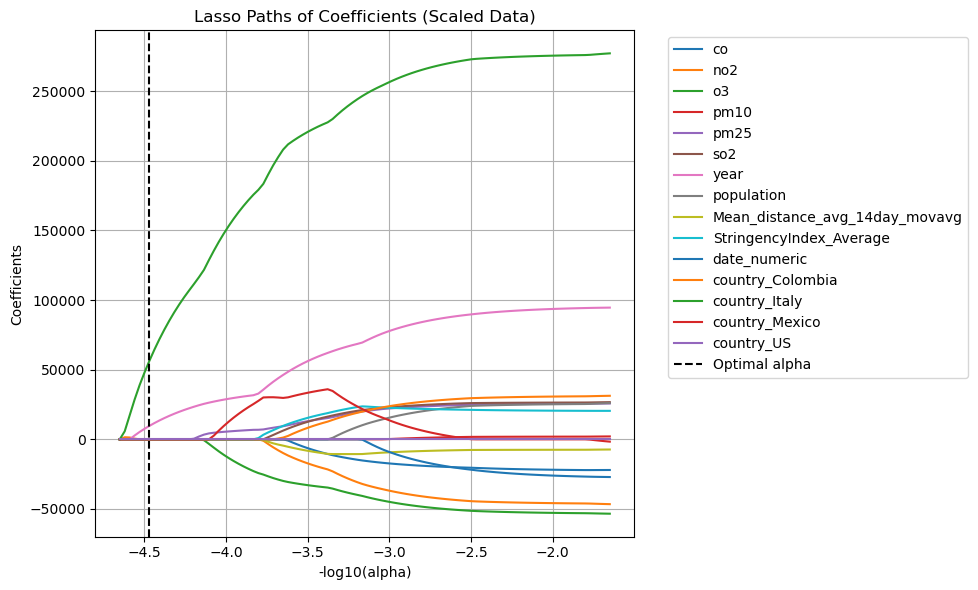

In [33]:
from sklearn.linear_model import lasso_path

# Compute coefficient paths using scaled data
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=lasso_cv.alphas_)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_lasso)

# Combine numeric and dummy feature names
feature_names = numeric_cols + dummy_cols

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_lasso, feature_names):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths of Coefficients (Scaled Data)')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


In [34]:
# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda)
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha (lambda): {best_alpha}")

# Predict on test set
y_pred = lasso_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[lasso_cv.coef_ != 0]
print(f"Selected features by Lasso: {list(selected_features)}")


Best alpha (lambda): 2178.8734713026265
RMSE: 823657.9314
R2: 0.0328
Selected features by Lasso: [np.str_('new_cases'), np.str_('cases'), np.str_('co'), np.str_('no2'), np.str_('o3'), np.str_('pm10'), np.str_('so2'), np.str_('year'), np.str_('population'), np.str_('Mean_distance_avg_14day_movavg')]


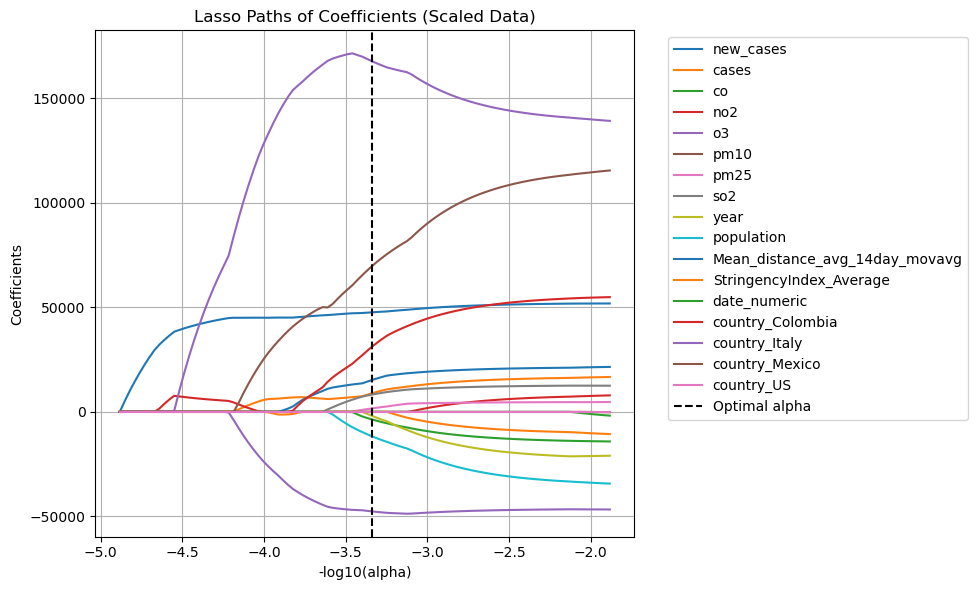

In [35]:
from sklearn.linear_model import lasso_path

# Compute coefficient paths using scaled data
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=lasso_cv.alphas_)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_lasso)

# Combine numeric and dummy feature names
feature_names = numeric_cols + dummy_cols

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_lasso, feature_names):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths of Coefficients (Scaled Data)')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

### Elastic Net

In [36]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda) and l1_ratio
elasticnet_cv = ElasticNetCV(cv=5, random_state=42, l1_ratio=[.1, .3,  .5, .7, .9, .95, .99, 1])

elasticnet_cv.fit(X_train_scaled, y_train)

# Best parameters
best_alpha = elasticnet_cv.alpha_
best_l1_ratio = elasticnet_cv.l1_ratio_
print(f"Best alpha (lambda): {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

# Predict on test set
y_pred = elasticnet_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[elasticnet_cv.coef_ != 0]
print(f"Selected features by ElasticNet: {list(selected_features)}")


Best alpha (lambda): 2178.8734713026265
Best l1_ratio: 1.0
RMSE: 823657.9314
R2: 0.0328
Selected features by ElasticNet: [np.str_('new_cases'), np.str_('cases'), np.str_('co'), np.str_('no2'), np.str_('o3'), np.str_('pm10'), np.str_('so2'), np.str_('year'), np.str_('population'), np.str_('Mean_distance_avg_14day_movavg')]


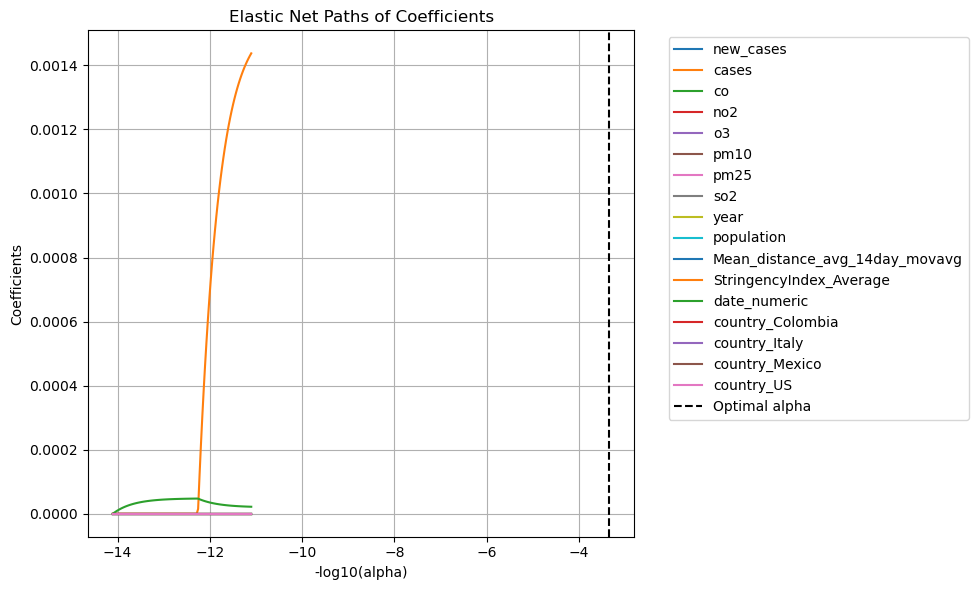

In [37]:
from sklearn.linear_model import enet_path
# Compute coefficient paths using enet_path
alphas_enet, coefs_enet, _ = enet_path(X_train, y_train, l1_ratio=best_l1_ratio)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_enet)

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_enet, X.columns):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Elastic Net Paths of Coefficients')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [38]:
# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases', 'cases_t_4', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Identify dummy (binary) columns
dummy_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numeric_cols = [col for col in X.columns if col not in dummy_cols]

# Scale only numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Reassemble scaled numeric columns and dummy columns
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[dummy_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[dummy_cols].values], axis=1)

# Cross-validation to find best alpha (lambda) and l1_ratio
elasticnet_cv = ElasticNetCV(cv=5, random_state=42, l1_ratio=[.1, .3,  .5, .7, .9, .95, .99, 1])

elasticnet_cv.fit(X_train_scaled, y_train)

# Best parameters
best_alpha = elasticnet_cv.alpha_
best_l1_ratio = elasticnet_cv.l1_ratio_
print(f"Best alpha (lambda): {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

# Predict on test set
y_pred = elasticnet_cv.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Selected features (non-zero coefficients)
selected_features = numeric_cols + dummy_cols
selected_features = np.array(selected_features)[elasticnet_cv.coef_ != 0]
print(f"Selected features by ElasticNet: {list(selected_features)}")

Best alpha (lambda): 29427.898217454665
Best l1_ratio: 1.0
RMSE: 1049003.7675
R2: -0.5573
Selected features by ElasticNet: [np.str_('co'), np.str_('no2'), np.str_('year')]


c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9763644753.029297, tolerance: 988290071.9158278
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24687603292.20117, tolerance: 988290071.9158278
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190397883729.10352, tolerance: 988290071.9158278
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sk

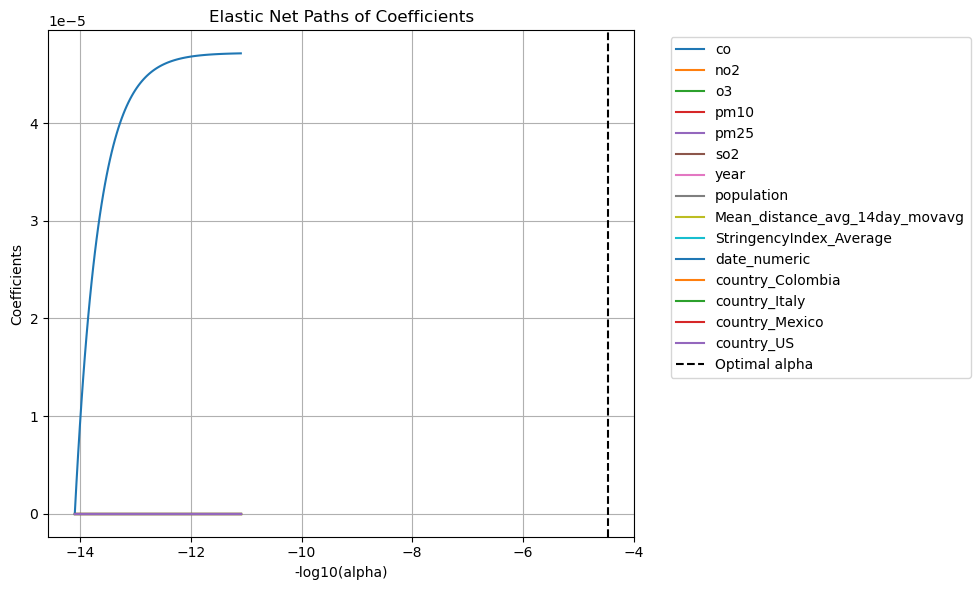

In [39]:
# Compute coefficient paths using enet_path
alphas_enet, coefs_enet, _ = enet_path(X_train, y_train, l1_ratio=best_l1_ratio)

# Plot coefficient paths
m_log_alphas = -np.log10(alphas_enet)

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_enet, X.columns):
    plt.plot(m_log_alphas, coef, label=feature)

plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Elastic Net Paths of Coefficients')
plt.axvline(-np.log10(best_alpha), linestyle='--', color='k', label='Optimal alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

## Random Forest

In [40]:
from sklearn.model_selection import GridSearchCV

# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases', 'cases_t_4', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# Reduced hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [50, 100, 200, 500],  # More options for tree count
    'max_depth': [None, 10, 20, 30],  # Allowing deeper trees
    'min_samples_split': [2, 5, 10],  # Controlling when to split nodes
    'min_samples_leaf': [1, 2, 5],  # Minimum samples required at leaf
    'max_features': ['sqrt', 'log2', None],  # Different feature selection strategies
    'bootstrap': [True, False]  # Whether to use bootstrapping
}


# Define model and grid search with reduced CV folds
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set
y_pred = grid_search.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}
RMSE: 1035531.2434
R2: -0.5176


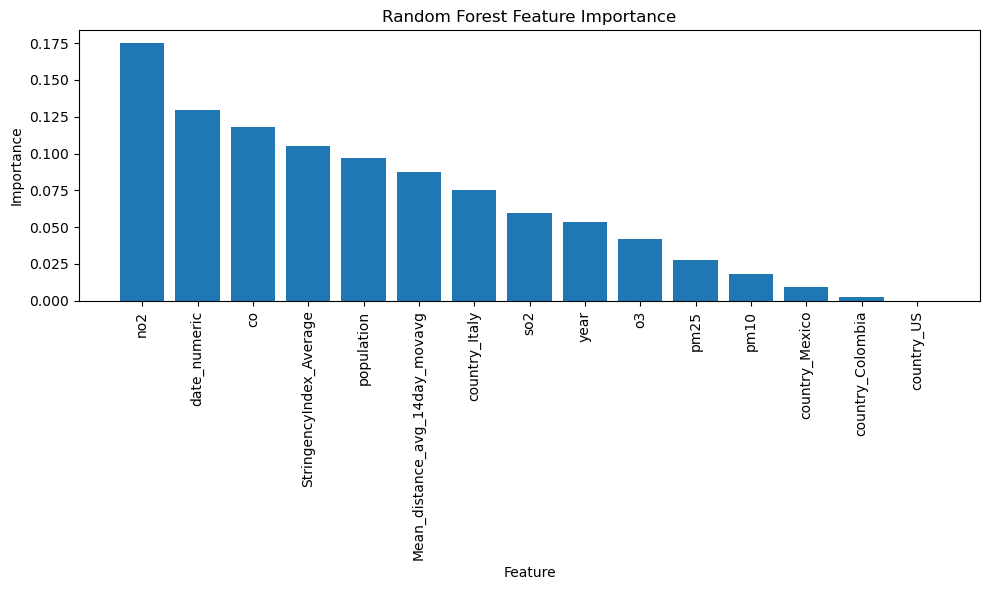

In [41]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = X.columns  # Corrected: Use actual feature names

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [42]:
# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# Reduced hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [50, 100, 200, 500],  # More options for tree count
    'max_depth': [None, 10, 20, 30],  # Allowing deeper trees
    'min_samples_split': [2, 5, 10],  # Controlling when to split nodes
    'min_samples_leaf': [1, 2, 5],  # Minimum samples required at leaf
    'max_features': ['sqrt', 'log2', None],  # Different feature selection strategies
    'bootstrap': [True, False]  # Whether to use bootstrapping
}


# Define model and grid search with reduced CV folds
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set
y_pred = grid_search.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 984937.5429
R2: -0.3831


In [43]:
from sklearn.metrics import r2_score

# Predict on the training set
y_train_pred = grid_search.predict(X_train)

# Calculate R² score for the training set
r2_train = r2_score(y_train, y_train_pred)
print(f"R² score for the training set: {r2_train:.4f}")

R² score for the training set: 0.8057


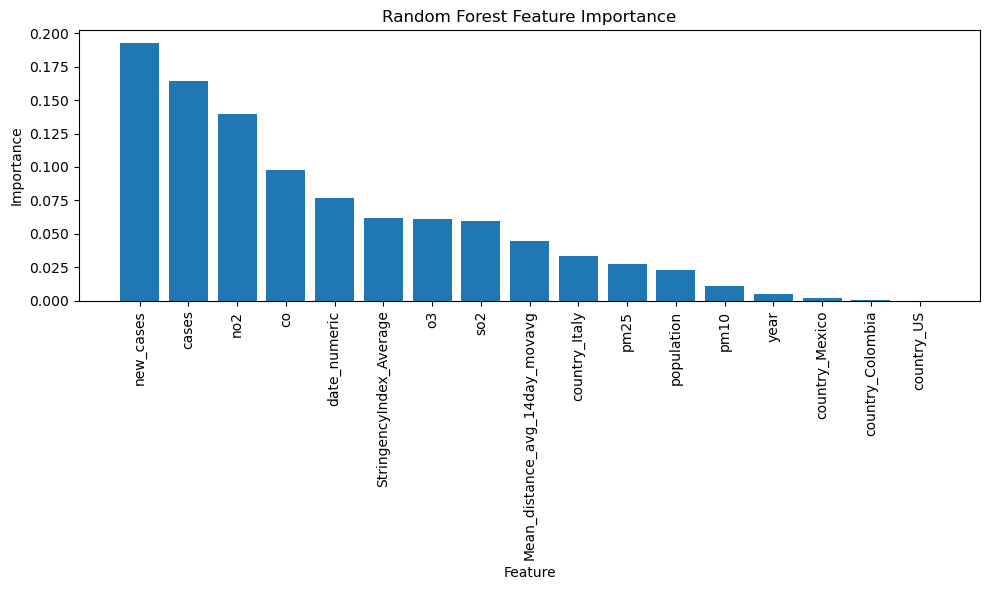

In [44]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = X.columns  # Corrected: Use actual feature names

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [45]:
# Define your target and features
target_variable = 'cases_t_1'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1', 'cases_t_4'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# Reduced hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [50, 100, 200, 500],  # More options for tree count
    'max_depth': [None, 10, 20, 30],  # Allowing deeper trees
    'min_samples_split': [2, 5, 10],  # Controlling when to split nodes
    'min_samples_leaf': [1, 2, 5],  # Minimum samples required at leaf
    'max_features': ['sqrt', 'log2', None],  # Different feature selection strategies
    'bootstrap': [True, False]  # Whether to use bootstrapping
}


# Define model and grid search with reduced CV folds
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set
y_pred = grid_search.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 758598.9400
R2: 0.1841


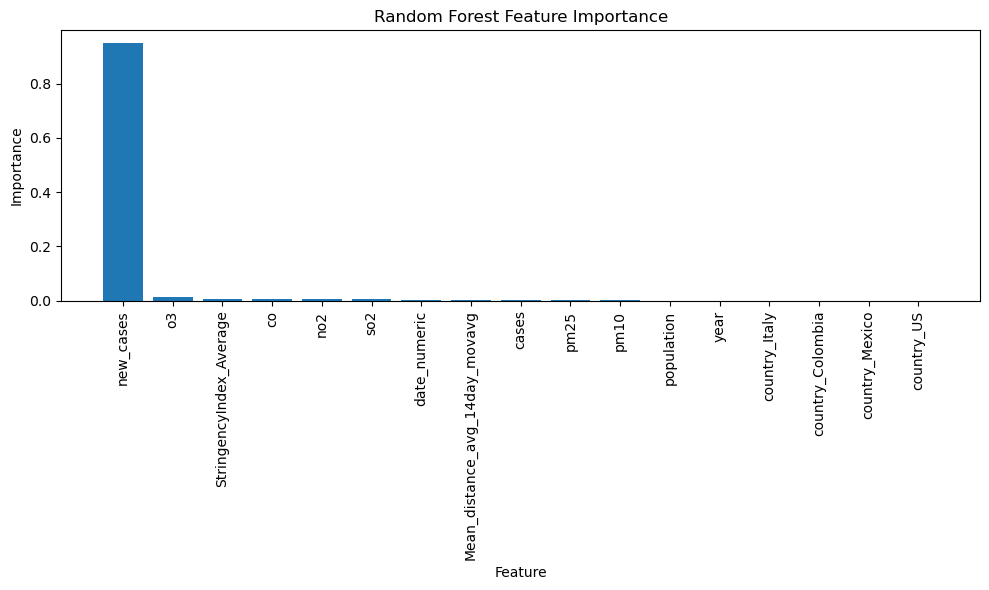

In [46]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
feature_names = X.columns  # Corrected: Use actual feature names

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

## Gradient Boosting

In [47]:
from sklearn.model_selection import RandomizedSearchCV
# Define your target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Hyperparameter optimization via GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],  # Number of boosting stages
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],  # Controls shrinkage
    'max_depth': [3, 5, 10, 15, None],  # Depth of individual trees
    'min_samples_split': [2, 5, 10, 20],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4, 10],  # Minimum samples at leaf nodes
    'max_features': ['sqrt', 'log2', None],  # Feature selection per split
    'subsample': [0.5, 0.7, 0.85, 1.0],  # Fraction of samples used for training each tree
    'loss': ['squared_error', 'absolute_error', 'huber'],  # Different loss functions
    'alpha': [0.85, 0.9, 0.95],  # Only applicable for Huber loss
}


# Initialize model
gbr = GradientBoostingRegressor(random_state=42)

# Use RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(
    gbr, param_grid, n_iter=30, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set with best estimator
y_pred = random_search.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 10, 'loss': 'absolute_error', 'learning_rate': 0.2, 'alpha': 0.85}
RMSE: 972376.0912
R2: -0.3480


In [48]:


# Predict on the training set
y_train_pred = random_search.predict(X_train)

# Calculate R² score for the training set
r2_train = r2_score(y_train, y_train_pred)
print(f"R² score for the training set: {r2_train:.4f}")

R² score for the training set: 0.7232


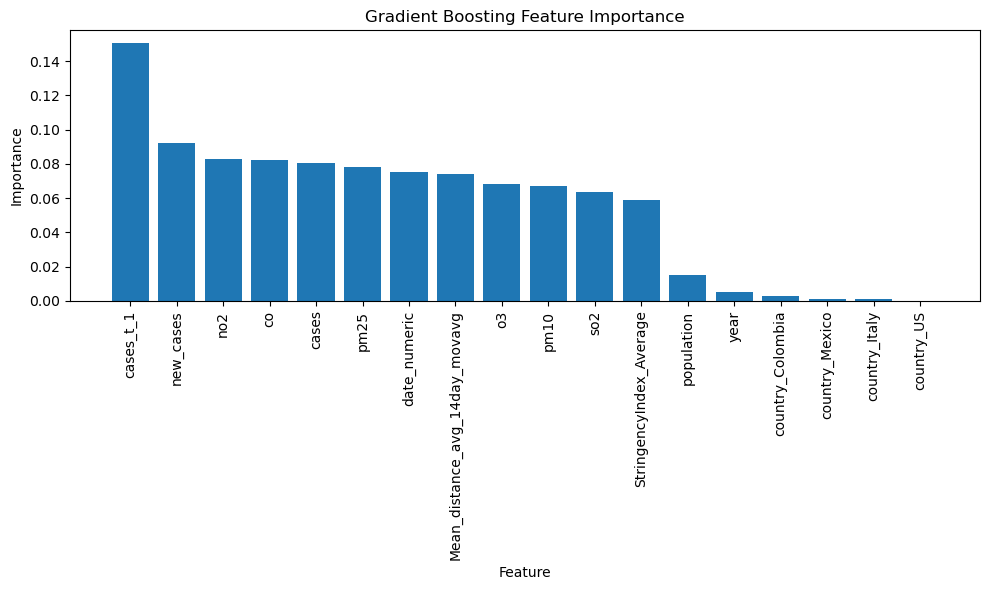

In [49]:
# Feature importance
importances = random_search.best_estimator_.feature_importances_
feature_names = X.columns  # Corrected: Use actual feature names

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Gradient Boosting Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [50]:
# Define your target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date',  'new_cases', 'cases_t_4', 'cases_t_1', 'cases'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# Hyperparameter optimization via GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],  # Number of boosting stages
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],  # Controls shrinkage
    'max_depth': [3, 5, 10, 15, None],  # Depth of individual trees
    'min_samples_split': [2, 5, 10, 20],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4, 10],  # Minimum samples at leaf nodes
    'max_features': ['sqrt', 'log2', None],  # Feature selection per split
    'subsample': [0.5, 0.7, 0.85, 1.0],  # Fraction of samples used for training each tree
    'loss': ['squared_error', 'absolute_error', 'huber'],  # Different loss functions
    'alpha': [0.85, 0.9, 0.95],  # Only applicable for Huber loss
}


# Initialize model
gbr = GradientBoostingRegressor(random_state=42)

# Use RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(
    gbr, param_grid, n_iter=30, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set with best estimator
y_pred = random_search.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'subsample': 0.5, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 5, 'loss': 'huber', 'learning_rate': 0.05, 'alpha': 0.9}
RMSE: 1000635.5218
R2: -0.4170


In [51]:
from sklearn.metrics import r2_score

# Predict on the training set
y_train_pred = random_search.predict(X_train)

# Calculate R² score for the training set
r2_train = r2_score(y_train, y_train_pred)
print(f"R² score for the training set: {r2_train:.4f}")

R² score for the training set: 0.6867


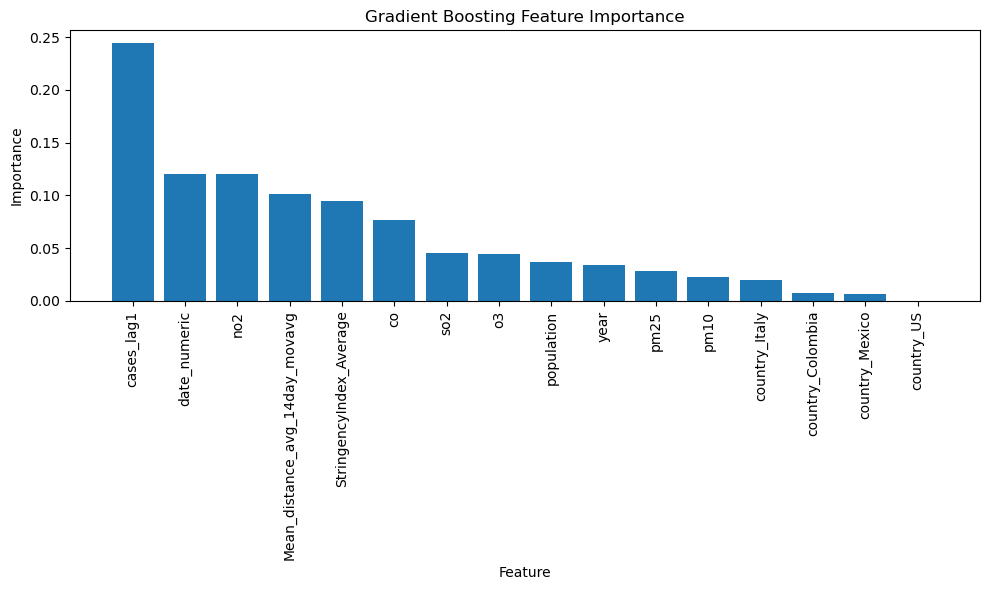

In [52]:
# Feature importance
importances = random_search.best_estimator_.feature_importances_
feature_names = X.columns  # Corrected: Use actual feature names

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Gradient Boosting Feature Importance')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


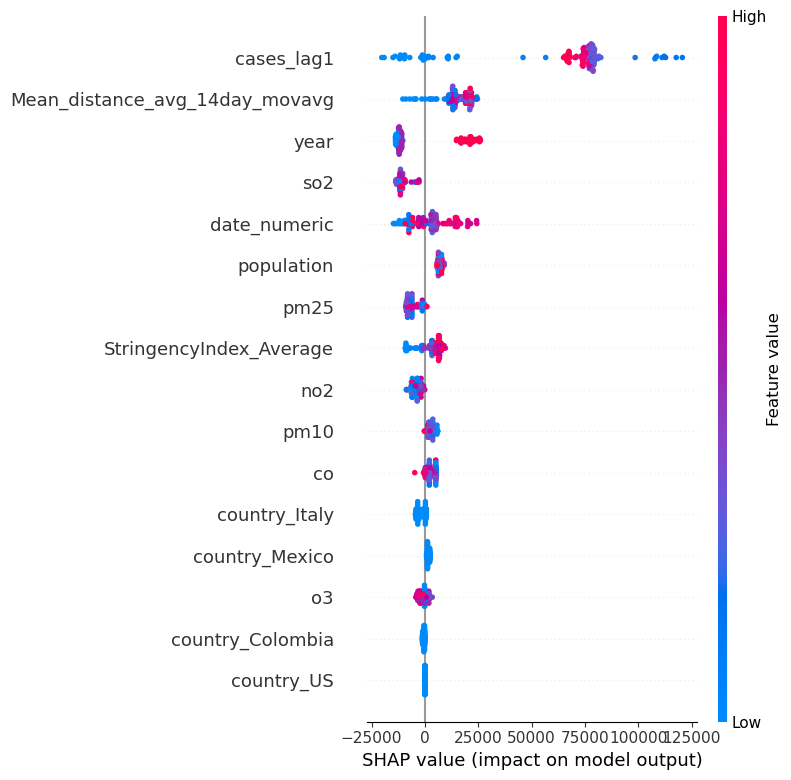

In [53]:
import shap
X_train = X_train.astype(float)  # Converts boolean to 0/1
X_test = X_test.astype(float)

# Initialize the SHAP explainer with the best estimator from the grid search
explainer = shap.Explainer(random_search.best_estimator_, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


## SVM

In [54]:
# Define target and features
target_variable = 'cases_t_4'
X = df.drop(columns=[target_variable, 'date', 'cases_lag1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Standardize features for SVR (important for kernel methods)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    'epsilon': [0.001, 0.01, 0.1, 0.2, 0.5],  # Defines the margin of tolerance
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid'],  # Different kernel types
    'degree': [2, 3, 4, 5]  # Only used for 'poly' kernel
}

# Initialize SVR model
svr = SVR()

# Hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    svr, param_grid, n_iter=30, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
random_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set with best estimator
y_pred = random_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


Best hyperparameters: {'kernel': 'poly', 'gamma': 1, 'epsilon': 0.5, 'degree': 3, 'C': 1}
RMSE: 3278172.9003
R2: -14.3211


In [55]:
# Predict on the training set
y_train_pred = random_search.predict(X_train)

# Calculate R² score for the training set
r2_train = r2_score(y_train, y_train_pred)
print(f"R² score for the training set: {r2_train:.4f}")

R² score for the training set: -42996757299558153464804715611451503335903854592.0000


c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


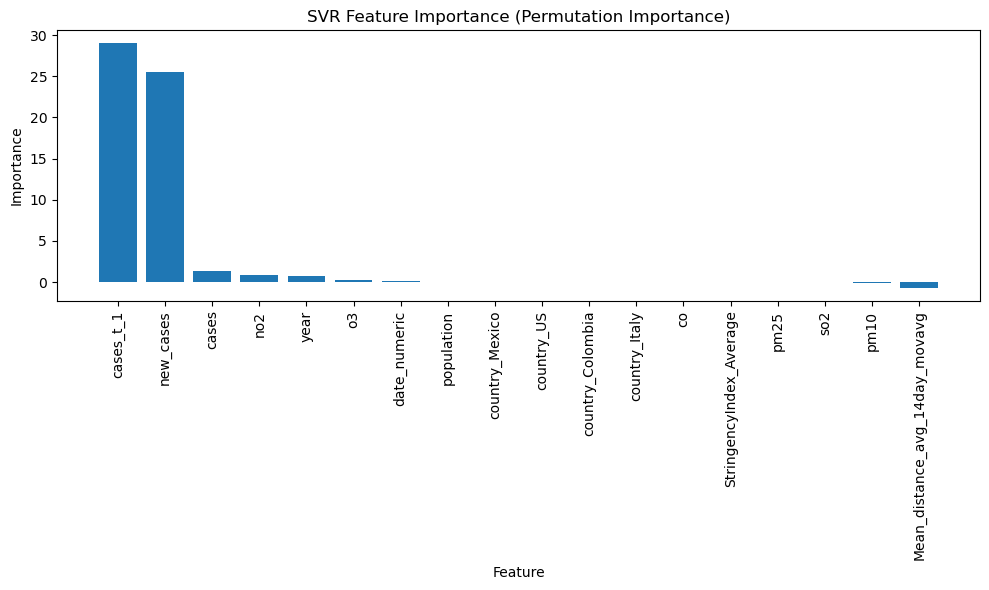

In [58]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(random_search.best_estimator_, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Extract importance scores
importances = perm_importance.importances_mean
feature_names = X.columns

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('SVR Feature Importance (Permutation Importance)')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [59]:
# Define target and features
target_variable = 'new_cases'
X = df.drop(columns=[target_variable, 'date', 'cases', 'cases_t_4', 'cases_t_1'])
y = df[target_variable]

# Train-test split (chronological)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Standardize features for SVR (important for kernel methods)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    'epsilon': [0.001, 0.01, 0.1, 0.2, 0.5],  # Defines the margin of tolerance
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid'],  # Different kernel types
    'degree': [2, 3, 4, 5]  # Only used for 'poly' kernel
}

# Initialize SVR model
svr = SVR()

# Hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    svr, param_grid, n_iter=30, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
random_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Predict on test set with best estimator
y_pred = random_search.predict(X_test_scaled)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

Best hyperparameters: {'kernel': 'poly', 'gamma': 1, 'epsilon': 0.5, 'degree': 3, 'C': 1}
RMSE: 1060994.0617
R2: -0.5931


In [60]:
# Predict on the training set
y_train_pred = random_search.predict(X_train)

# Calculate R² score for the training set
r2_train = r2_score(y_train, y_train_pred)
print(f"R² score for the training set: {r2_train:.4f}")

R² score for the training set: -1346599132986177123903556387752443877370934329344.0000


c:\Users\danie\anaconda3\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


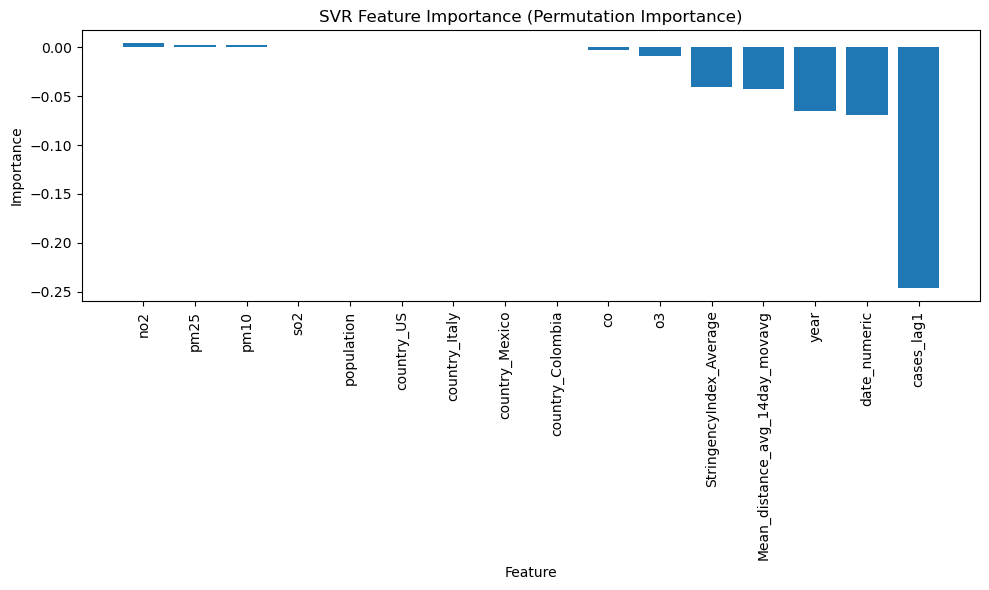

In [61]:
# Compute permutation importance
perm_importance = permutation_importance(random_search.best_estimator_, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Extract importance scores
importances = perm_importance.importances_mean
feature_names = X.columns

# Plot feature importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('SVR Feature Importance (Permutation Importance)')
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()
